<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Word Embeddings con Glove y Fasttext

Este código permite levantar los embeddings de fastText y de GloVe y poder utilizarlos para calcular la distancia entre palabras

In [1]:
import logging

import os
from pathlib import Path
from io import StringIO
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Datos

In [2]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
# Download fastText Embeddings 
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

# Download GloVe Embeddings
!curl -L -o 'gloveembedding.pkl' 'https://drive.google.com/u/0/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download&confirm=t'

curl: (3) URL using bad/illegal format or missing URL
curl: (3) URL using bad/illegal format or missing URL
"export" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.
"confirm" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [ ]:
# De donde se obtuvieron estos embeddings:

# Link de donde se dscargo los embeddings de GloVe (de ese zip solo se sube el embedding de 50d)
# http://nlp.stanford.edu/data/glove.twitter.27B.zip
# Link de descarga de los embeddings 300 de fastText
# https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz

In [ ]:
# Paper de GloVe
# https://nlp.stanford.edu/pubs/glove.pdf

# Papers de FastText
# https://arxiv.org/pdf/1607.04606.pdf
# https://arxiv.org/abs/1607.01759
# https://arxiv.org/abs/1612.03651

### 1 - Ensayar los embeddings de Glove y Fasttext

In [20]:
# Acá definimos una clase que nos va a permitir manejar los embeddings de GloVe
# y fastText con la misma interfase.
# Incluye cómo cargar los embeddings a partir de sus pickles 
# (formato de datos serializados de Python) y guardarlos
# funciones para obtener términos dados índices y viceversa

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings

# Armamos clases particulares para manejar los embeddings de Glove y Fasttext
# que heredan de la clase anterior WordsEmbeddings
class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [21]:
# Creamos los generadores de embeddings
# Puede demorar 1 minuto porque tiene que levantar los archivos de embeddings
model_fasttext = FasttextEmbeddings()
model_glove = GloveEmbeddings()

In [22]:
# Armamos una función para graficar la matriz de similaridad
def plot_matrix_distance(words, dist):
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot()
    sns.heatmap(dist, xticklabels=words, yticklabels=words, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
    plt.show()

In [23]:
# Ojo que si usan scipy la distancia coseno no es la similitud coseno (esta "negada")
from sklearn.metrics import pairwise

def embeddings_matrix_distance(model, words):
    print("Cantidad de palabras:", len(words))
    emb = model.get_words_embeddings(words)
    print("Dimensiones de los embeddings:", emb.shape)
    dist = pairwise.cosine_similarity(emb, emb)
    plot_matrix_distance(words, dist)

In [24]:
# Palabras a ensayar
# Algunas relativas con saludos y otras con dispositivos
words = ["hi", "hello", "bye", "goodbye", "morning", "computer", "machine", "laptop", "device", "printer"]

Cantidad de palabras: 10
Dimensiones de los embeddings: (10, 50)


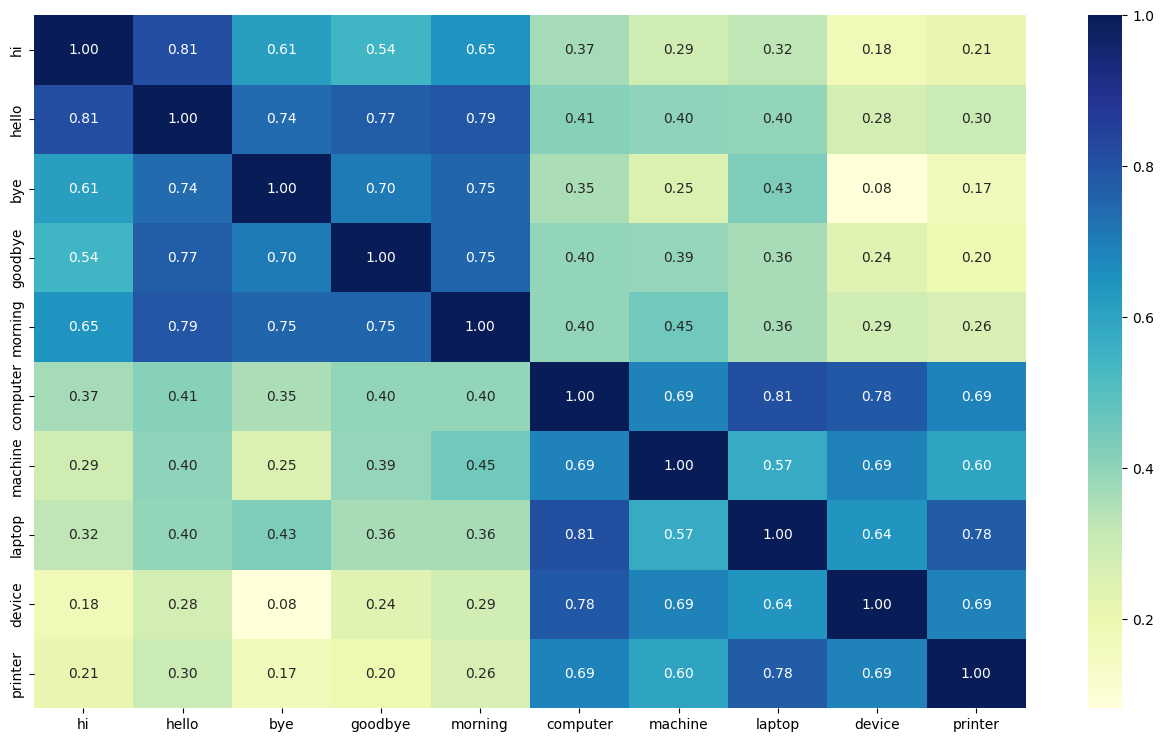

In [25]:
embeddings_matrix_distance(model_glove, words)

Cantidad de palabras: 10
Dimensiones de los embeddings: (10, 300)


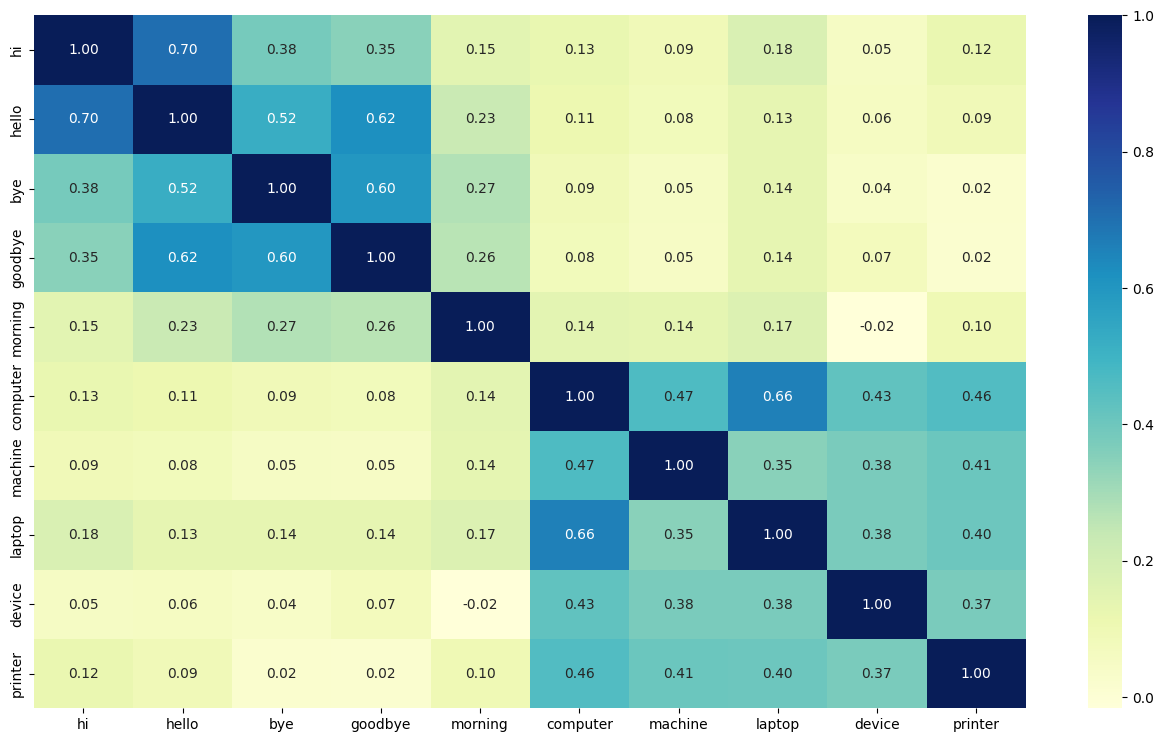

In [26]:
embeddings_matrix_distance(model_fasttext, words)

### 2 - Conclusión hasta el momento
Como era esperado no es igual el resultado, y cada uno tiene sus ventajas según lo que se desea lograr.
- En los embeddings de Glove morning está muy relacionado con los saludos y este comportamiento podría no ser deseado.
- En los embeddings de Fasttext la similitud entre los dos grupos de palabras elegidas no es tan alta.

### 3 - Operaciones con embeddings (reyes y reinas)

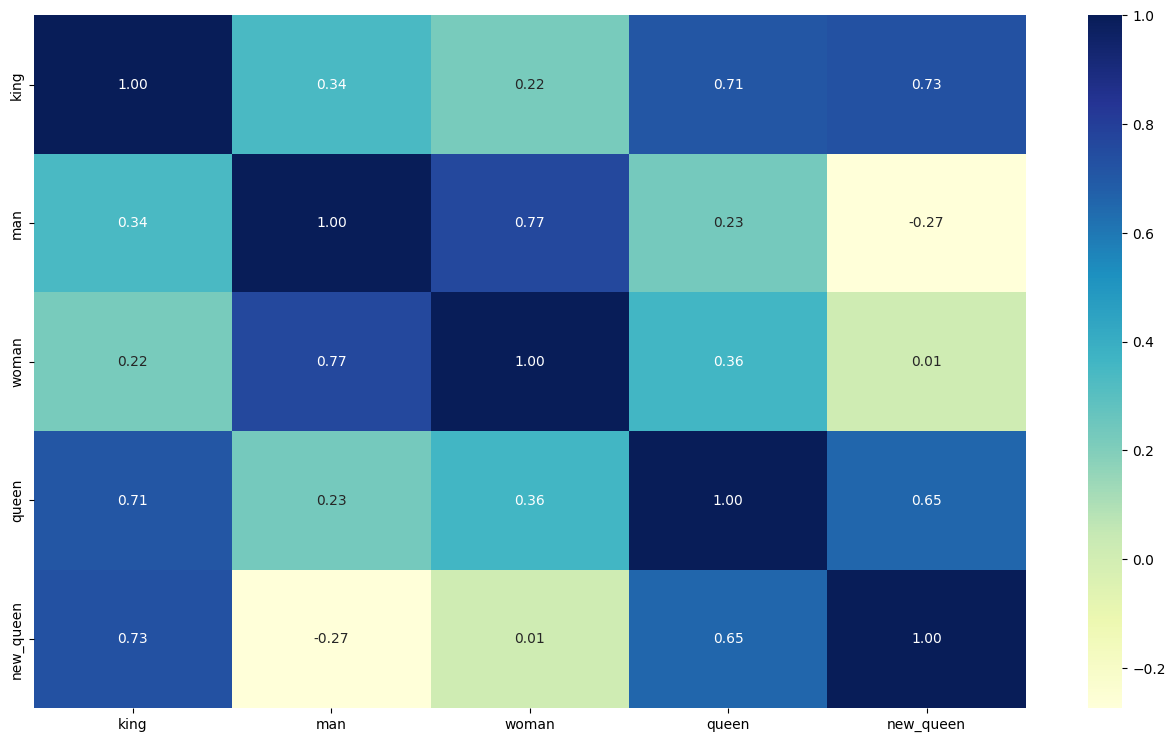

In [27]:
test_words = ['king', 'man', 'woman', 'queen']
test_emb = model_fasttext.get_words_embeddings(test_words)

# king - man + woman
new_queen = test_emb[0] - test_emb[1] + test_emb[2]

new_words = test_words + ['new_queen']
new_emb = np.append(test_emb, new_queen.reshape(1, -1), axis=0)

dist = pairwise.cosine_similarity(new_emb, new_emb)

plot_matrix_distance(new_words, dist)

In [ ]:
# ¿cuál es el término más similar al vector `new_queen`?

# armamos una lista con todo el vocabulario soportado for fasttext
words_fasttext=[model_fasttext.embeddings[i][0] for i in range(model_fasttext.embeddings.shape[0])]

# armamos un array con todos los vectores de fasttext
vect_fasttext = []
for idx,vect in enumerate(model_fasttext.embeddings):
  vect_fasttext.append(vect[1])

vect_fasttext = np.array(vect_fasttext)

In [ ]:
# calculamos la similaridad entre nuestro vector `new_queen` y todos los de fasttext
similarities = pairwise.cosine_similarity([new_queen],vect_fasttext)

In [ ]:
# vemos a qué palabra corresponde la similaridad más alta
words_fasttext[np.argmax(similarities)]

### 5 - Conclusiones
Se puede observar que la similitud entre "queen" y "new_queen" no es tan alta como uno esperaría y esto depende del generador de embeddings, pero:
- Está más cerca "new_queen" a "queen" de lo que está "woman" o "man"
- Es cierto que "king" está más cerca de "queen" que "new_queen" pero es mutuo.
- Están bastante cerca "man" y "woman" y es por eso que la operación realizada tiene sentido

### 6 - Jugando con otras operaciones

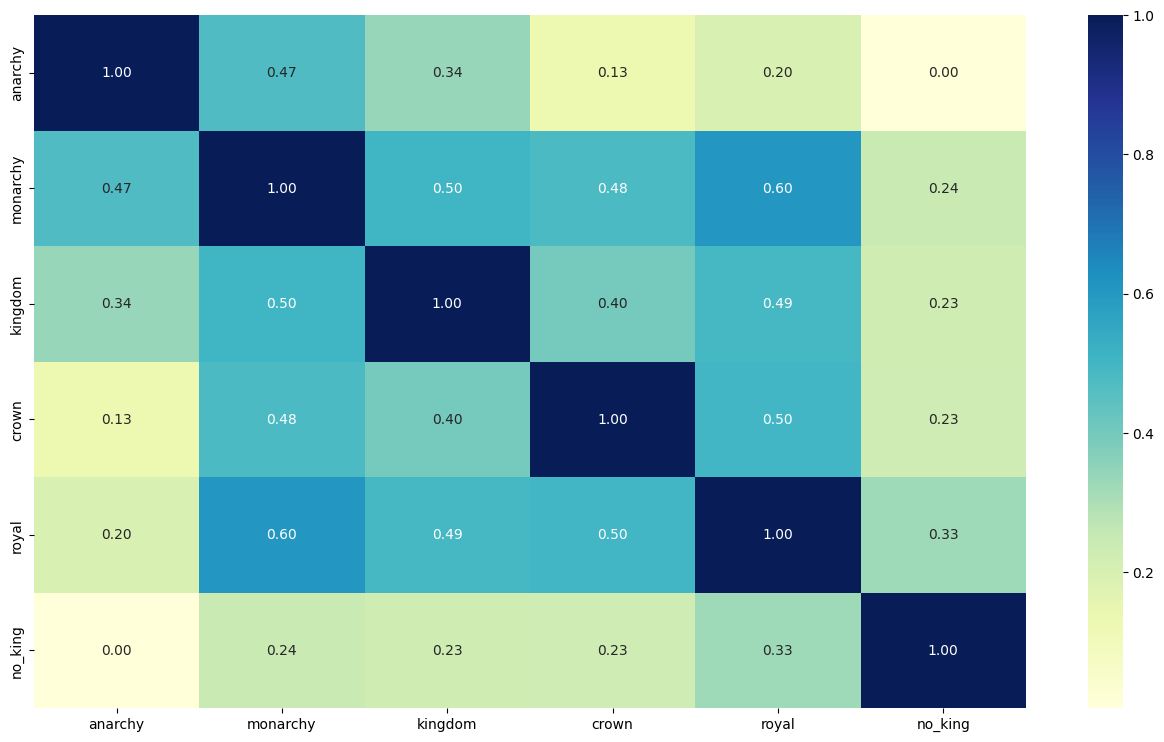

In [28]:
test_words2 = ['anarchy', 'monarchy', 'kingdom', 'crown', 'royal']
test_emb2 = model_fasttext.get_words_embeddings(test_words2)

# king - man
no_king = test_emb[0] - test_emb[1]

new_words2 = test_words2 + ['no_king']
new_emb2 = np.append(test_emb2, no_king.reshape(1, -1), axis=0)

dist2 = pairwise.cosine_similarity(new_emb2, new_emb2)

plot_matrix_distance(new_words2, dist2)

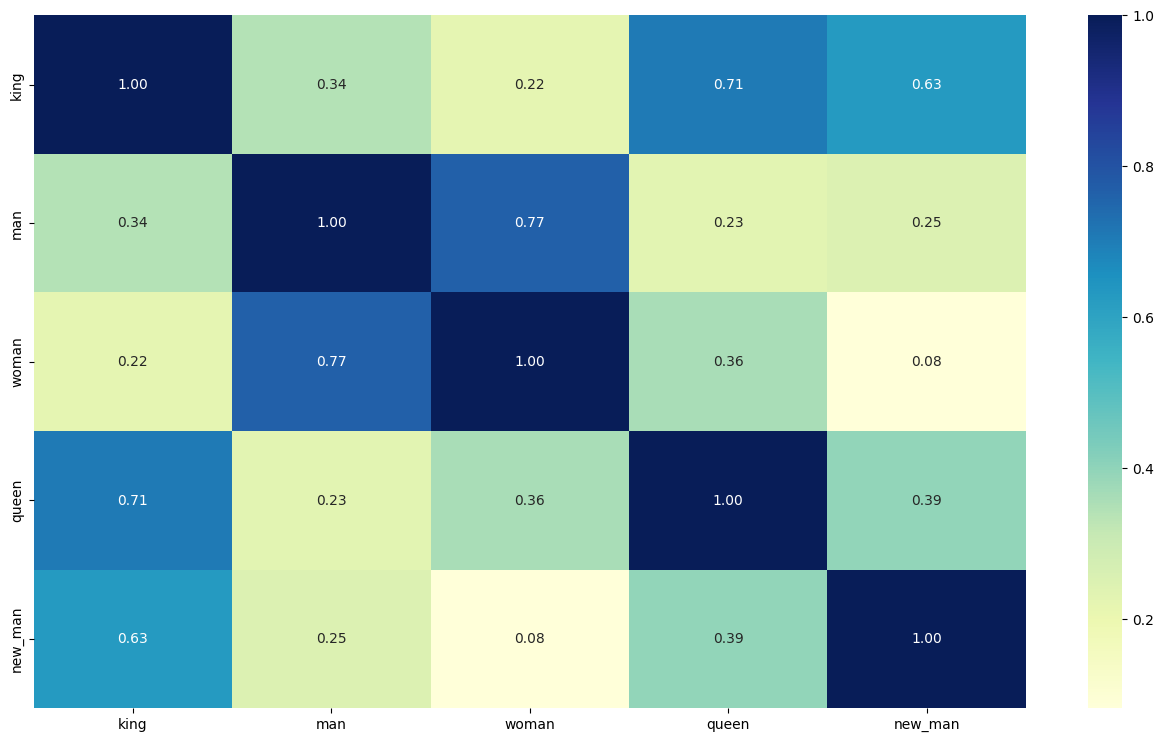

In [29]:
# king - royal
new_man = test_emb[0] - test_emb2[4]

new_words3 = test_words + ['new_man']
new_emb3 = np.append(test_emb, new_man.reshape(1, -1), axis=0)

dist3 = pairwise.cosine_similarity(new_emb3, new_emb3)

plot_matrix_distance(new_words3, dist3)

### 7 - Interpretación gráfica de reyes y reinas
Utilizaramos TSNE para representar los embeddings y dos dimensiones y poder compararlos. En una de la mejores formas de reducir la dimensionalidad de embeddings para comparación visual.

In [30]:
import numpy as np
from sklearn.manifold import TSNE

<Axes: >

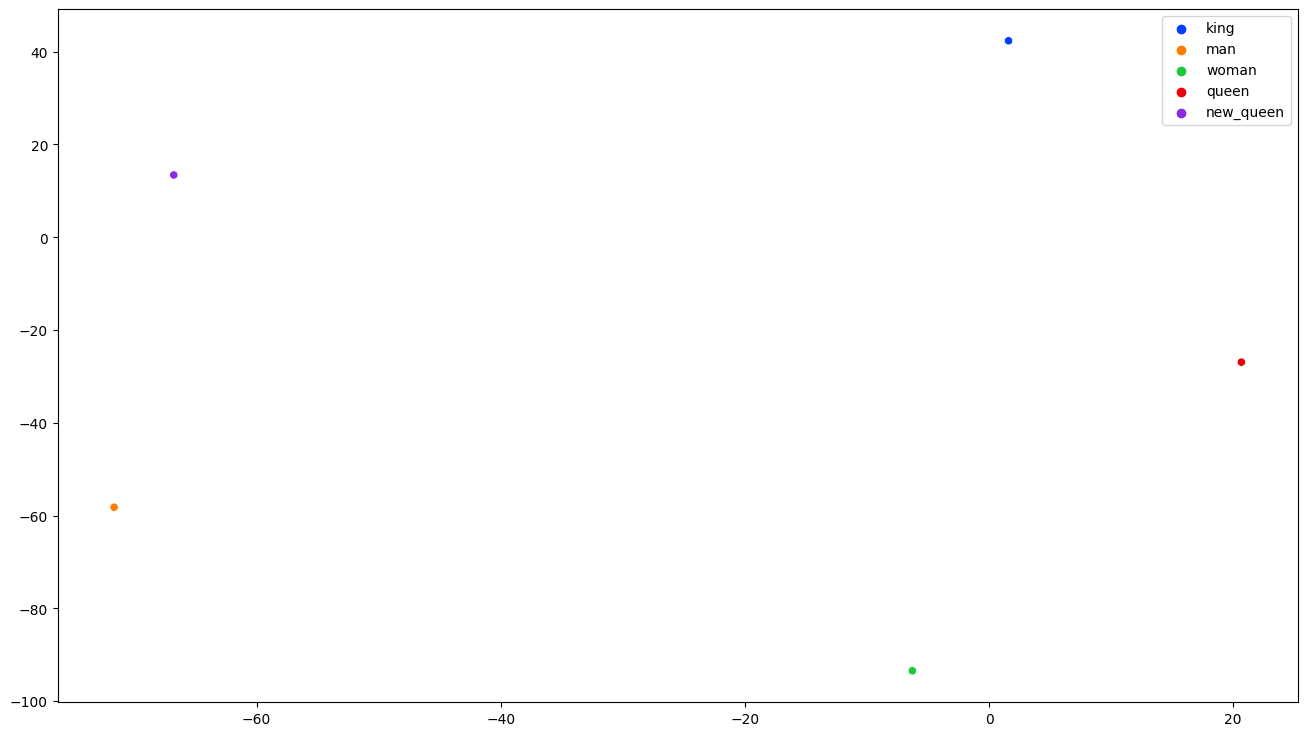

In [31]:
# Visualizar los primeros embeddings calculados, con "queen" y "new_queen"
X = np.asanyarray(new_emb) # son los embeddings
y = np.asanyarray(new_words) # son los strings

# Si bien se puede incluir X e y en el método fit_transform de TSNE, y es ignorado
# ya que se transforman sólo los datos en X
# el parámetro de perplexity debe ser menor a la cantidad de datos a transformar
X_embedded = TSNE(n_components=2,perplexity=4.0).fit_transform(X, y)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette='bright', ax=ax)

<Axes: >

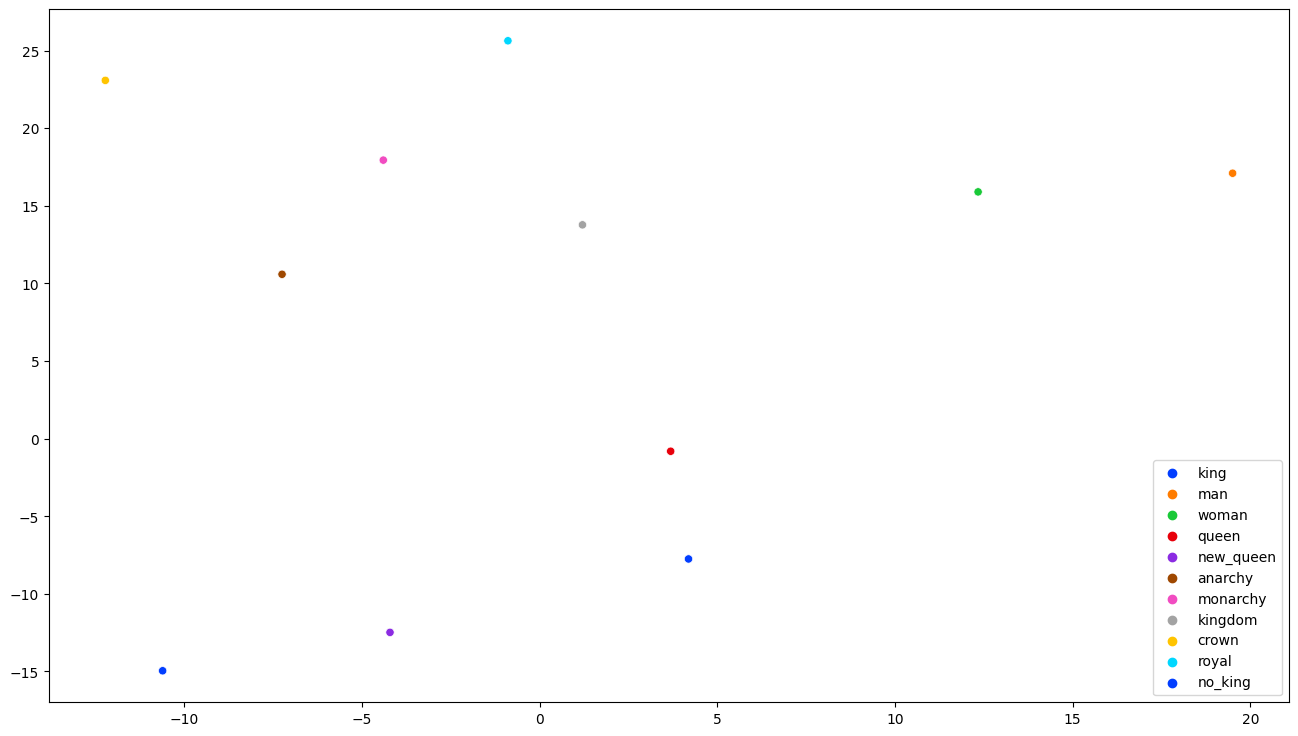

In [32]:
# Visualizar todos los embeddings calculados, con "new_queen" y "no_king"
X = np.asanyarray(np.append(new_emb, new_emb2, axis=0))
y = np.asanyarray(new_words + new_words2)

X_embedded = TSNE(n_components=2,perplexity=5.0).fit_transform(X, y)

fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot()
sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=y, palette='bright', ax=ax)